In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
import re
import matplotlib.colors as mcolors
from data_utils import plot_workload
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib import gridspec

HOME_DIR = os.getcwd()

In [2]:
os.chdir(HOME_DIR)
os.chdir("../experiment_results/rho_stepwise")
files = ['uniform.csv', 
         'unimodal_1.csv', 'unimodal_2.csv', 'unimodal_3.csv', 'unimodal_4.csv', 
         'bimodal_1.csv', 'bimodal_2.csv', 'bimodal_3.csv', 'bimodal_4.csv', 'bimodal_5.csv', 'bimodal_6.csv',
         'trimodal_1.csv', 'trimodal_2.csv', 'trimodal_3.csv', 'trimodal_4.csv'
        ]

## Grouping by Epsilon

In [3]:
from pprint import pprint

First, we construct a cost matrix that arranges the different percent changes in cost so that 
- cost_matrix[0, 0] (upper left) corresponds to $E(\rho) = 2$ and $\frac{1}{\varepsilon} = 1$
- cost_matrix[m, 0] (bottom left) corresponds to $E(\rho) = 0$ and $\frac{1}{\varepsilon} = 1$
- cost_matrix[0, m] (upper right) corresponds to $E(\rho) = 2$ and $\frac{1}{\varepsilon} = 20$

We use $\frac{1}{\varepsilon}$ so moving towards the right represents an increase in privacy. Moving up represents an increase in the neighborhood given to Endure's robust tuner. 

In [4]:
def prepare_cost_matrix(filename): 
    df = pd.read_csv(filename)
    df['Percent Change'] = (df['Robust Cost'] - df['Nominal Cost'])/df['Nominal Cost']
    # The higher, the more private 
    df['Epsilon Invert'] = df['Epsilon'].apply(lambda x: 1/x)
    df = df.sort_values(by=['Rho', 'Epsilon Invert'])

    # setting x (epsilon_invert) and y (rho) axis for the graph
    epsilon_invert = np.sort(df['Epsilon Invert'].unique())
    rho_values = np.sort(df['Rho'].unique())
    # we invert them because [0, 0] corresponds to upper left corner in imshow
    epsilon_invert = epsilon_invert[::-1]
    rho_values = rho_values[::-1]

    # setup cost matrix 
    cost_matrix = np.zeros((len(rho_values), len(epsilon_invert)))
    for i, rho in enumerate(rho_values):
        for j, eps in enumerate(epsilon_invert): 
            # find the corresponding percent change value, given a specific rho and epsilon invert
            percent_change = df[(df['Rho'] == rho) & (df['Epsilon Invert'] == eps)]['Percent Change'].iloc[0]
            cost_matrix[i, j] = percent_change
    
    return cost_matrix, epsilon_invert, rho_values

In [5]:
def plot_heatmap(cost_matrix, epsilon_invert, rho_values, 
                 fig, ax, name='', cost_mins=None, cost_maxs=None): 
    im = ax.imshow(cost_matrix, 
                   extent=[min(epsilon_invert), round(max(epsilon_invert), 1), min(rho_values), max(rho_values)], 
                   vmin=np.min(cost_mins), 
                   vmax=np.median(cost_maxs) # to avoid outliers 
                  )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Percent Change in Cost')  
    ax.set_title(name)
    ax.set_xlabel(r"1 / $\varepsilon$")  
    ax.set_ylabel(r"$\rho$") 
    ax.set_aspect('auto')

In [6]:
cost_matrix_all = []
cost_maxs = []
cost_mins = []
filenames = []

for file in files: 
    cost_matrix, epsilon_invert, rho_values = prepare_cost_matrix(file)
    filenames += [file]
    cost_mins += [np.min(cost_matrix)]
    cost_maxs += [np.max(cost_matrix)]
    cost_matrix_all += [cost_matrix]

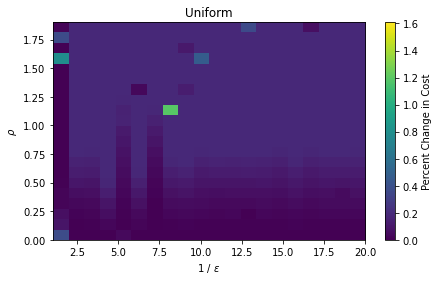

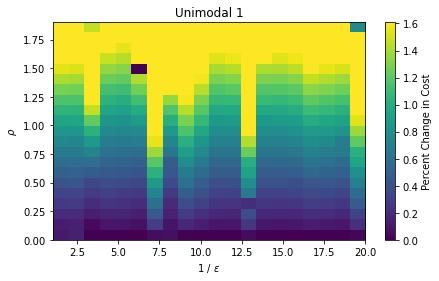

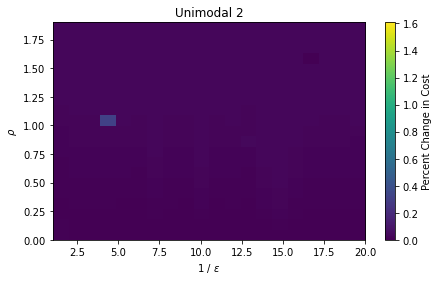

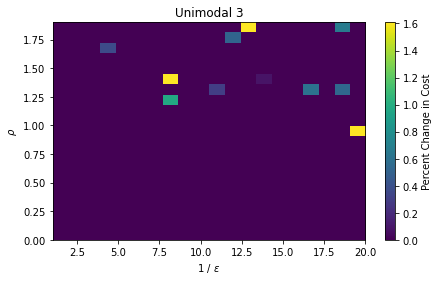

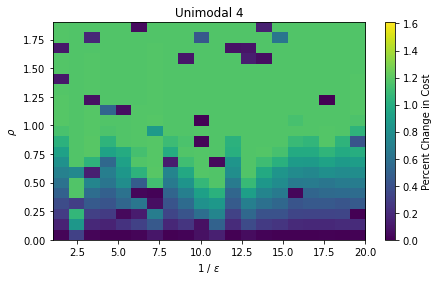

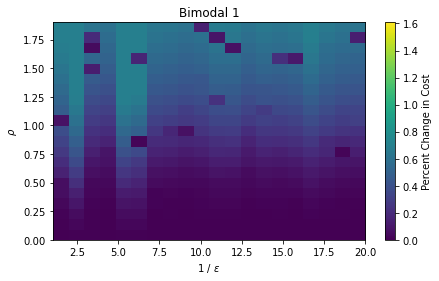

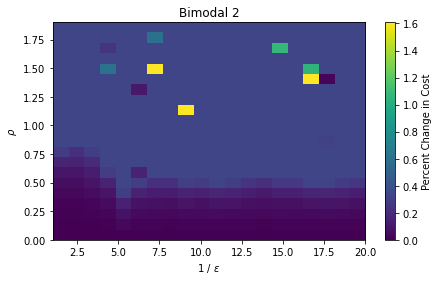

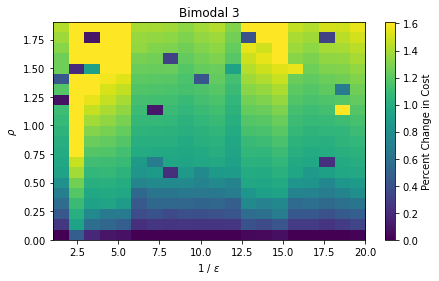

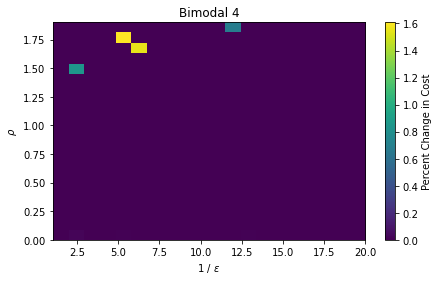

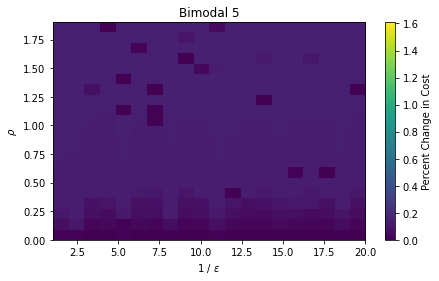

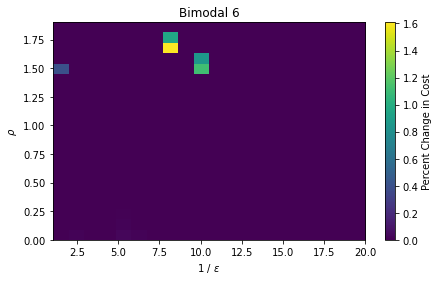

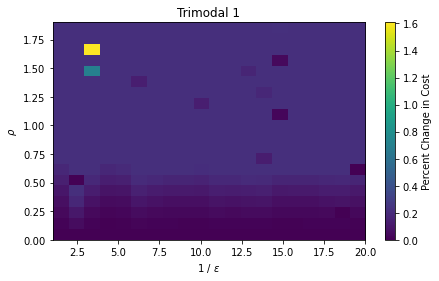

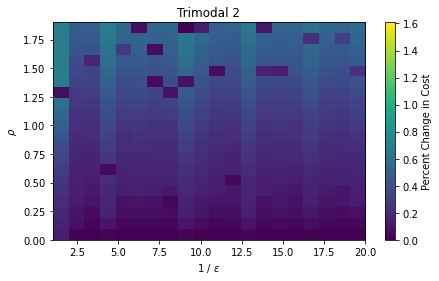

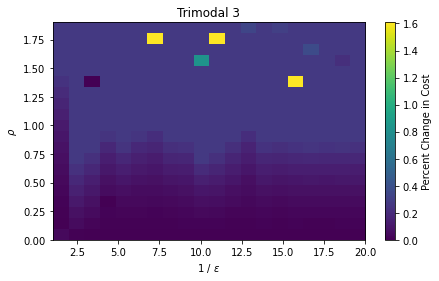

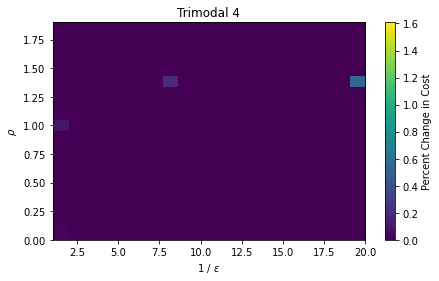

In [7]:
for i in range(len(filenames)): 
    fig, ax = plt.subplots(figsize=(7, 4))
    cost_matrix = cost_matrix_all[i]
    name = filenames[i].split('.')[0]
    name = name.replace('_', ' ')
    name = name.capitalize()
    plot_heatmap(cost_matrix, epsilon_invert, rho_values, 
                 fig, ax, name=name, cost_mins=cost_mins, cost_maxs=cost_maxs)
    filename_base = files[i].split('.')[0]
    fig.savefig(f"../../notebook/graphs/static_rho/{filename_base}_workloads_plot.png", dpi=300, bbox_inches='tight')

## Plotting Workload Neighborhoods

#### Graphs with many large percent change

Average True ρ: 0.01951
Standard Dev True ρ: 0.03047


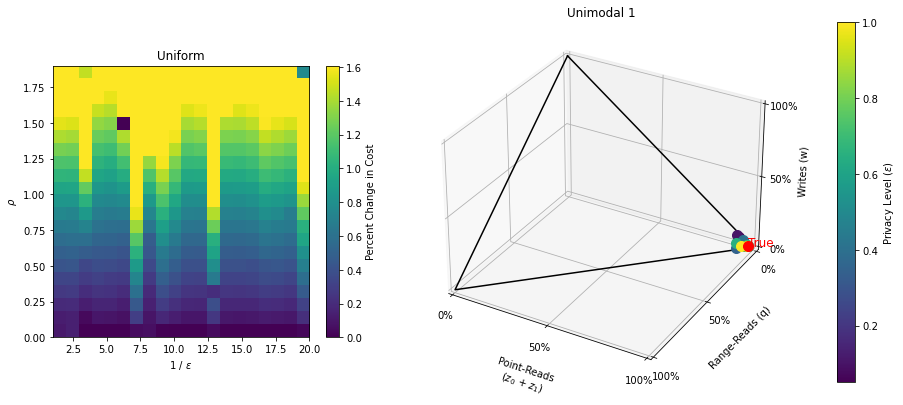

Average True ρ: 0.02966
Standard Dev True ρ: 0.03785


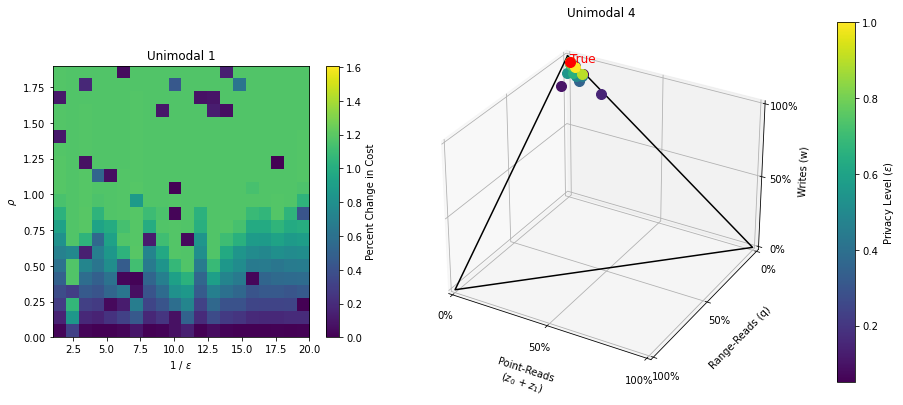

In [8]:
large_change = ['unimodal_1.csv', 'unimodal_4.csv']
for i, file in enumerate(large_change): 
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.3, 1])
    df = pd.read_csv(file)
    print("Average True \u03C1:", round(df['Rho (True)'].mean(), 5))
    print("Standard Dev True \u03C1:", round(df['Rho (True)'].std(), 5))
    idx = filenames.index(file)
    name = filenames[i].split('.')[0]
    name = name.replace('_', ' ')
    name = name.capitalize()
    cost_matrix = cost_matrix_all[idx]
    ax1 = fig.add_subplot(gs[0])
    plot_heatmap(cost_matrix, epsilon_invert, rho_values, 
                 fig=fig, ax=ax1, name=name, cost_mins=cost_mins, cost_maxs=cost_maxs)
    ax2 = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax2)
    plot_workload(file, fig, ax2, anchor=(0.01, 0)) 
    plt.show()

#### Graphs with almost no change 

Average True ρ: 0.01936
Standard Dev True ρ: 0.02547


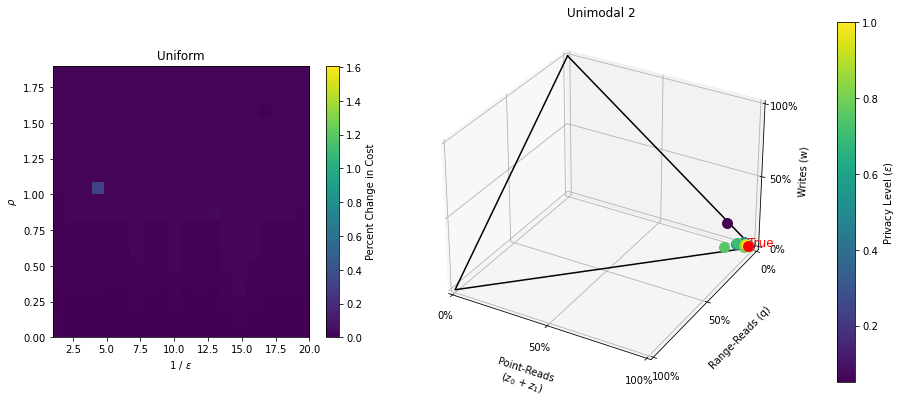

Average True ρ: 0.03673
Standard Dev True ρ: 0.10059


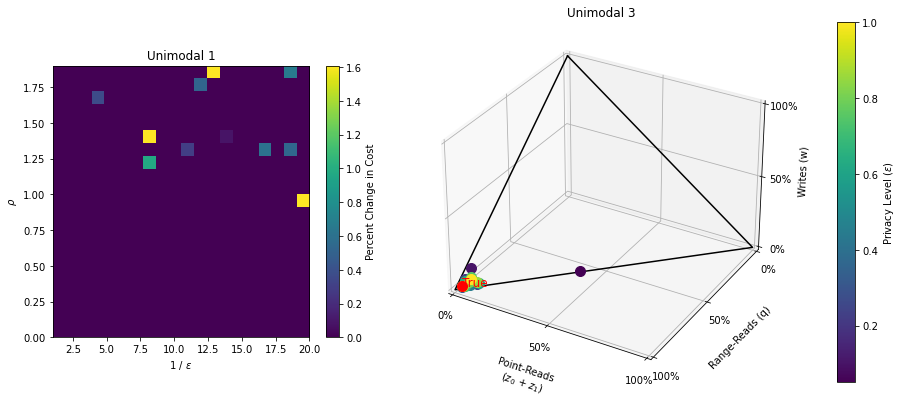

Average True ρ: 0.06892
Standard Dev True ρ: 0.1875


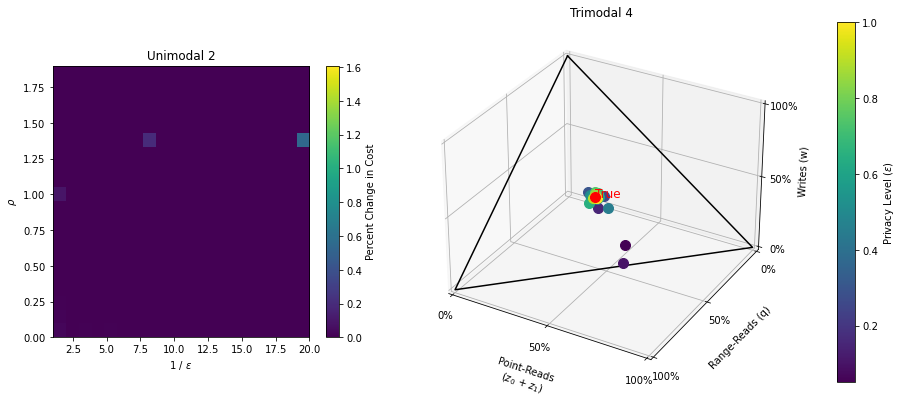

In [9]:
no_change = ['unimodal_2.csv', 'unimodal_3.csv', 'trimodal_4.csv']

for i, file in enumerate(no_change): 
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.3, 1])
    df = pd.read_csv(file)
    print("Average True \u03C1:", round(df['Rho (True)'].mean(), 5))
    print("Standard Dev True \u03C1:", round(df['Rho (True)'].std(), 5))
    idx = filenames.index(file)
    name = filenames[i].split('.')[0]
    name = name.replace('_', ' ')
    name = name.capitalize()
    cost_matrix = cost_matrix_all[idx]
    ax1 = fig.add_subplot(gs[0])
    plot_heatmap(cost_matrix, epsilon_invert, rho_values, 
                 fig=fig, ax=ax1, name=name, cost_mins=cost_mins, cost_maxs=cost_maxs)
    ax2 = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax2)
    plot_workload(file, fig, ax2, anchor=(0.01, 0)) 
    plt.show()

#### Graphs with some change 

Average True ρ: 0.08333
Standard Dev True ρ: 0.2071


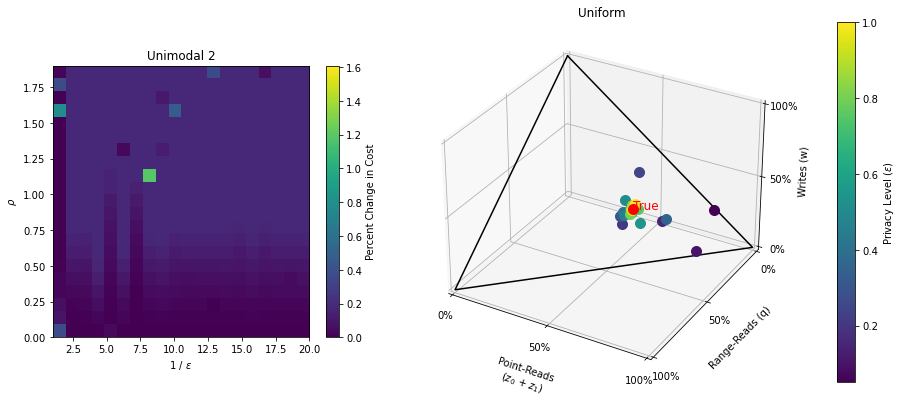

Average True ρ: 0.01571
Standard Dev True ρ: 0.03728


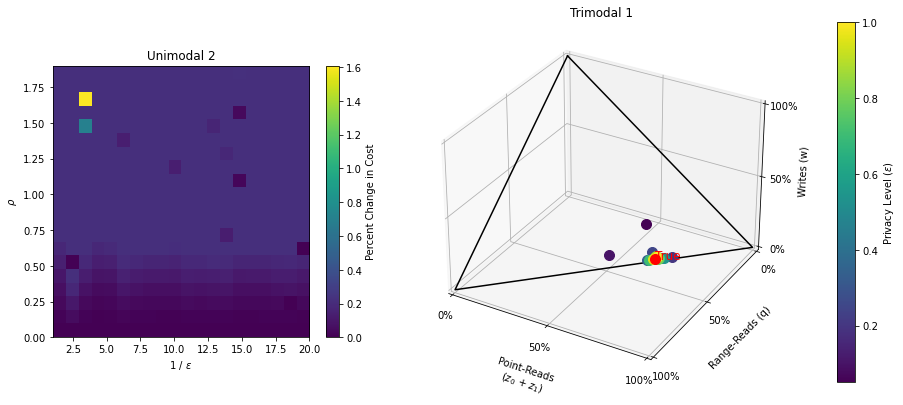

Average True ρ: 0.01435
Standard Dev True ρ: 0.0321


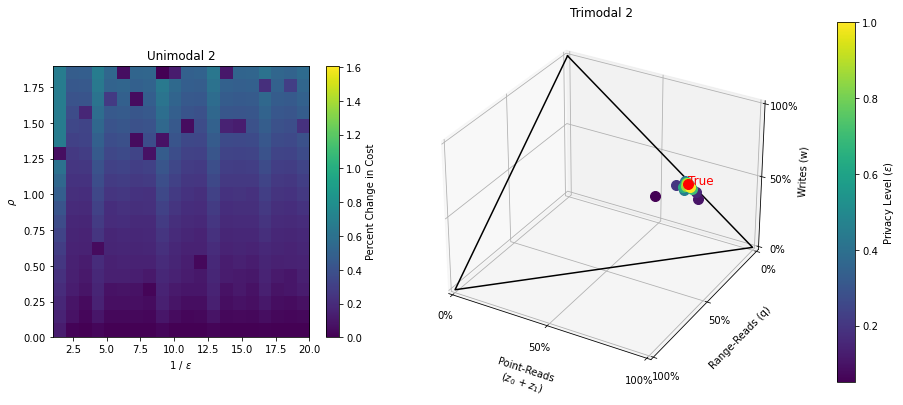

Average True ρ: 0.01858
Standard Dev True ρ: 0.03306


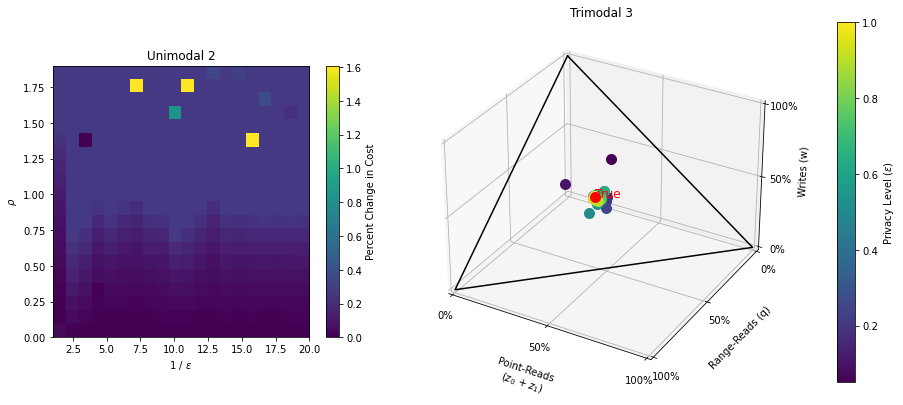

In [10]:
some_change = ['uniform.csv', 'trimodal_1.csv', 'trimodal_2.csv', 'trimodal_3.csv']

for i, file in enumerate(some_change): 
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.3, 1])
    df = pd.read_csv(file)
    print("Average True \u03C1:", round(df['Rho (True)'].mean(), 5))
    print("Standard Dev True \u03C1:", round(df['Rho (True)'].std(), 5))
    idx = filenames.index(file)
    cost_matrix = cost_matrix_all[idx]
    ax1 = fig.add_subplot(gs[0])
    plot_heatmap(cost_matrix, epsilon_invert, rho_values, 
                 fig=fig, ax=ax1, name=name, cost_mins=cost_mins, cost_maxs=cost_maxs)
    ax2 = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax2)
    plot_workload(file, fig, ax2, anchor=(0.01, 0)) 
    plt.show()